In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

replicating local resources


In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
TensorFlow 2.x selected.


'2.1.0'

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [6]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2020-02-29 01:26:59--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9.5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9.48M  57.4MB/s    in 0.2s    

2020-02-29 01:26:59 (57.4 MB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

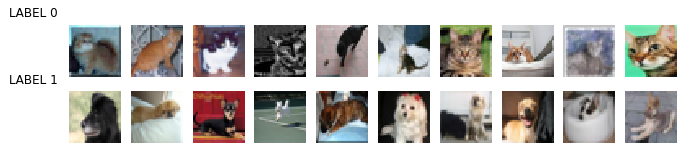

In [7]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
1    406
0    394
dtype: int64

distribution of test classes
0    109
1     91
dtype: int64


## Part 1: train a model with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [0]:
def get_model(num_classes, img_size=32, compile=True):
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [11]:
model1 = get_model(num_classes=len(np.unique(y_cifar)))
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3904      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160  

In [12]:
train(model1, batch_size=32, epochs=10, model_name="model_C")

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/sample - loss: 0.7032 - accuracy: 0.5025 - val_loss: 0.7020 - val_accuracy: 0.4550
Epoch 2/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6966 - accuracy: 0.5125 - val_loss: 0.6964 - val_accuracy: 0.4550
Epoch 3/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6940 - accuracy: 0.4925 - val_loss: 0.6939 - val_accuracy: 0.4350
Epoch 4/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6927 - accuracy: 0.5038 - val_loss: 0.6975 - val_accuracy: 0.4150
Epoch 5/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6929 - accuracy: 0.5050 - val_loss: 0.6938 - val_accuracy: 0.4800
Epoch 6/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6917 - accuracy: 0.5412 - val_loss: 0.6944 - val_accuracy: 0.4500
Epoch 7/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6919 - accur

{'accuracy': 0.58, 'loss': 0.6801351308822632}

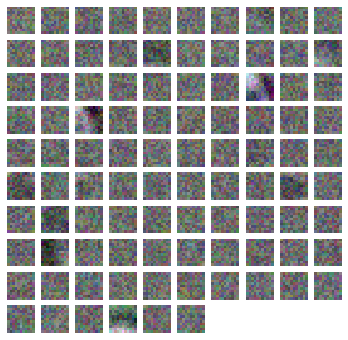

In [13]:
mlutils.display_imgs(model1.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [15]:
!unzip alexnet_finetuned_minicifar.model.zip

Archive:  alexnet_finetuned_minicifar.model.zip
   creating: alexnet_finetuned_minicifar.model/
   creating: alexnet_finetuned_minicifar.model/variables/
  inflating: alexnet_finetuned_minicifar.model/variables/variables.data-00000-of-00001  
  inflating: alexnet_finetuned_minicifar.model/variables/variables.index  
   creating: alexnet_finetuned_minicifar.model/assets/
  inflating: alexnet_finetuned_minicifar.model/saved_model.pb  


In [16]:
from tensorflow.keras.models import load_model

model1 = get_model(num_classes=len(np.unique(y_cifar)))
model2 = load_model("alexnet_finetuned_minicifar.model")
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_3 (Flatten)          (None, 60)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                976 

In [0]:
#w1 = ... # obtain weights of model 1
#w2 = ... # obtain weights of model 2

w1 = model1.get_weights()
w2 = model2.get_weights()

In [19]:
print (" -- model 1 weights --")
... # print all weights shapes of model 1
for i in w1:
    print (i.shape)

 -- model 1 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 64)
(64,)
(64, 64)
(64,)
(64, 2)
(2,)


In [20]:
print (" -- model 2 weights --")
# ... # print all weights shapes of model 2
for i in w2:
    print (i.shape)

 -- model 2 weights --
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [21]:
 # ... 
for i in range(4):
    assert np.allclose(w2[i].shape, w1[i].shape), "weights structure not equal "+str(w1[i].shape)+", "+str(w2[i].shape)
    print ("copying weights", i, "-->", w1[i].shape)
    w1[i] = w2[i].copy()

copying weights 0 --> (11, 11, 3, 96)
copying weights 1 --> (96,)
copying weights 2 --> (11, 11, 96, 60)
copying weights 3 --> (60,)


In [0]:
model1.set_weights(w1)

### train!!!

In [23]:
#train(... )
train(model1, batch_size=16, epochs=10, model_name="model_C")

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/sample - loss: 0.7260 - accuracy: 0.4775 - val_loss: 0.6956 - val_accuracy: 0.5100
Epoch 2/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6889 - accuracy: 0.5475 - val_loss: 0.6832 - val_accuracy: 0.5700
Epoch 3/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.6436 - accuracy: 0.6150 - val_loss: 0.6785 - val_accuracy: 0.5800
Epoch 4/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.5678 - accuracy: 0.7038 - val_loss: 0.7597 - val_accuracy: 0.5900
Epoch 5/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.5119 - accuracy: 0.7188 - val_loss: 0.7542 - val_accuracy: 0.5800
Epoch 6/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.4334 - accuracy: 0.7962 - val_loss: 0.8215 - val_accuracy: 0.6250
Epoch 7/10
800/800 [==============================] - 3s 4ms/sample - loss: 0.3437 - accur

{'accuracy': 0.63, 'loss': 1.2348823261260986}

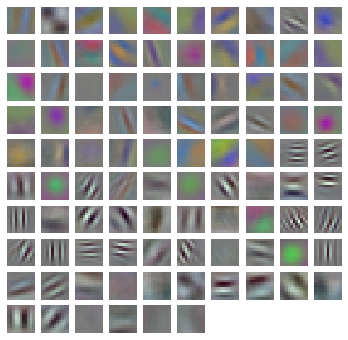

In [24]:
mlutils.display_imgs(model1.get_weights()[0])